In [0]:
# !pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
# !pip3 install torchvision

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import Parameter
import torch.nn.functional as F
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import torch.optim as optim
import math

import matplotlib.pyplot as plt

# MNIST Dataset 
train_dataset = MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),  
                            download=True)

test_dataset = MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
trainloader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=64, 
                                           shuffle=True)

testloader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=64, 
                                          shuffle=False)

batchsize = 64
learning_rate = 0.02

h0, h1, h2, h3 = 784, 800, 800, 10

num_parameters = h0 * h1 + h1 + h1 * h2 + h2 + h2 * h3 + h3
print('total number of parameters: {:,}'.format(num_parameters))



total number of parameters: 1,276,810


In [35]:
for (X_train, y_train) in trainloader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([64, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([64]) type: torch.LongTensor


In [0]:
class MLP(torch.nn.Module):
  def __init__(self, in_features, hidden1_size, hidden2_size, out_features):
    super(MLP, self).__init__()
    d1 = math.sqrt(6 / (in_features + hidden1_size))
    d2 = math.sqrt(6 / (hidden1_size + hidden2_size))
    d3 = math.sqrt(6 / (out_features + hidden2_size))
    self.w1 = Parameter(torch.Tensor(hidden1_size, in_features))
    self.b1 = Parameter(torch.Tensor(hidden1_size))
    self.w1.data.uniform_(-d1, d1)
    self.b1.data.fill_(0.0)
    self.w2 = Parameter(torch.Tensor(hidden2_size, hidden1_size))
    self.b2 = Parameter(torch.Tensor(hidden2_size))
    self.w2.data.uniform_(-d2, d2)
    self.b2.data.fill_(0.0)
    self.w3 = Parameter(torch.Tensor(out_features, hidden2_size))
    self.b3 = Parameter(torch.Tensor(out_features))
    self.w3.data.uniform_(-d3, d3)
    self.b3.data.fill_(0.0)

  def forward(self, x):
    x = x.view(-1, 28*28)
    h1 = F.linear(x, self.w1, self.b1)
    x = F.relu(h1)
    h2 = F.linear(x, self.w2, self.b2)
    x = F.relu(h2)
    h3 = F.linear(x, self.w3, self.b3)
    return h3


In [3]:
cuda = torch.cuda.is_available()
print('Using PyTorch version:', torch.__version__, 'CUDA:', cuda)

torch.manual_seed(42)
if cuda:
    torch.cuda.manual_seed(42)

Using PyTorch version: 0.3.0.post4 CUDA: True


In [0]:
def test(model, testloader, loss_vector, accuracy_vector):
    model.eval()
    test_loss, correct = 0, 0
    for data, target in testloader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss /= len(testloader)
    loss_vector.append(test_loss)

    accuracy = 100. * correct / len(testloader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset), accuracy))
    return loss_vector, accuracy_vector

In [0]:
def train(model, optimizer, trainloader, testloader, num_epochs, learning_rate, log_interval=100):
    lossv, accv = [], []
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer

    num_minibatches = int(np.ceil(len(trainloader.dataset)/(batchsize+0.0)))

    l2_norms = np.zeros(num_epochs * num_minibatches, dtype=np.float16)
    
    for epoch in range(1, num_epochs + 1):
      for batch_idx, (data, target) in enumerate(trainloader):
          if cuda:
              data, target = data.cuda(), target.cuda()
          data, target = Variable(data), Variable(target)

          optimizer.zero_grad()
          output = model(data)
          loss = criterion(output, target)
          loss.backward()
          optimizer.step()

          norm_params = 0
          for params in model.parameters():
              l2_norms[(epoch - 1) * num_minibatches + batch_idx] += torch.norm(params)


          if batch_idx % log_interval == 0:
              print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch, batch_idx * len(data), len(trainloader.dataset),
                  100. * batch_idx / len(trainloader), loss.data[0]))

      lossv, accv = test(model, trainloader, lossv, accv)

    print(len(l2_norms))
    return l2_norms, lossv, accv
            

In [47]:
batchsize = 64
learning_rate = 0.02

h0, h1, h2, h3 = 784, 800, 800, 10

num_parameters = h0 * h1 + h1 + h1 * h2 + h2 + h2 * h3 + h3
print('total number of parameters: {:,}'.format(num_parameters))

# %%time
epochs = 100
model1 = MLP(h0, h1, h2, h3)
if cuda:
    model1.cuda()

weights = [parameter for name, parameter in model1.named_parameters() if 'w' in name]
biases = [parameter for name, parameter in model1.named_parameters() if 'b' in name]

num_minibatches = int(np.ceil(len(trainloader.dataset)/(batchsize+0.0)))
optimizer1 = torch.optim.SGD([
               {'params': biases},
               {'params': weights, 'weight_decay': 2.5/num_minibatches}
           ], lr=learning_rate)

norms1, lossv1, accv1 = train(model1, optimizer1, trainloader, testloader, epochs, learning_rate)

total number of parameters: 1,276,810
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.373599
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.098147
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.561492
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.561691
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.708061
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.345311
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.310750
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.346250
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.312677
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.271025

Test set: Average loss: 0.3121, Accuracy: 54675/60000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.368621
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.238871
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.215677
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.219453
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.219518
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.398614
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.301606
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.500806
Train Epoch:

Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.120398

Test set: Average loss: 0.1592, Accuracy: 57414/60000 (96%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.136367
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.098567
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.107345
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.087621
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.160380
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.139472
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.248813
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.138765
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.166523
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.074774

Test set: Average loss: 0.1507, Accuracy: 57566/60000 (96%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.140280
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.295861
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.112612
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.159314
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.079690
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.135475
Train Epoch: 8 [38400/60000 (64%)]	Los

Train Epoch: 12 [51200/60000 (85%)]	Loss: 0.087579
Train Epoch: 12 [57600/60000 (96%)]	Loss: 0.070983

Test set: Average loss: 0.1156, Accuracy: 58247/60000 (97%)

Train Epoch: 13 [0/60000 (0%)]	Loss: 0.100283
Train Epoch: 13 [6400/60000 (11%)]	Loss: 0.084612
Train Epoch: 13 [12800/60000 (21%)]	Loss: 0.130776
Train Epoch: 13 [19200/60000 (32%)]	Loss: 0.092242
Train Epoch: 13 [25600/60000 (43%)]	Loss: 0.099963
Train Epoch: 13 [32000/60000 (53%)]	Loss: 0.077830
Train Epoch: 13 [38400/60000 (64%)]	Loss: 0.069603
Train Epoch: 13 [44800/60000 (75%)]	Loss: 0.070367
Train Epoch: 13 [51200/60000 (85%)]	Loss: 0.109801
Train Epoch: 13 [57600/60000 (96%)]	Loss: 0.147486

Test set: Average loss: 0.1144, Accuracy: 58268/60000 (97%)

Train Epoch: 14 [0/60000 (0%)]	Loss: 0.078101
Train Epoch: 14 [6400/60000 (11%)]	Loss: 0.172764
Train Epoch: 14 [12800/60000 (21%)]	Loss: 0.163544
Train Epoch: 14 [19200/60000 (32%)]	Loss: 0.058436
Train Epoch: 14 [25600/60000 (43%)]	Loss: 0.116748
Train Epoch: 14 [3200

Train Epoch: 18 [38400/60000 (64%)]	Loss: 0.055850
Train Epoch: 18 [44800/60000 (75%)]	Loss: 0.104999
Train Epoch: 18 [51200/60000 (85%)]	Loss: 0.123347
Train Epoch: 18 [57600/60000 (96%)]	Loss: 0.195224

Test set: Average loss: 0.0989, Accuracy: 58566/60000 (98%)

Train Epoch: 19 [0/60000 (0%)]	Loss: 0.068003
Train Epoch: 19 [6400/60000 (11%)]	Loss: 0.107705
Train Epoch: 19 [12800/60000 (21%)]	Loss: 0.132291
Train Epoch: 19 [19200/60000 (32%)]	Loss: 0.084524
Train Epoch: 19 [25600/60000 (43%)]	Loss: 0.066478
Train Epoch: 19 [32000/60000 (53%)]	Loss: 0.104906
Train Epoch: 19 [38400/60000 (64%)]	Loss: 0.100920
Train Epoch: 19 [44800/60000 (75%)]	Loss: 0.096877
Train Epoch: 19 [51200/60000 (85%)]	Loss: 0.124429
Train Epoch: 19 [57600/60000 (96%)]	Loss: 0.076486

Test set: Average loss: 0.0976, Accuracy: 58567/60000 (98%)

Train Epoch: 20 [0/60000 (0%)]	Loss: 0.053415
Train Epoch: 20 [6400/60000 (11%)]	Loss: 0.098231
Train Epoch: 20 [12800/60000 (21%)]	Loss: 0.117724
Train Epoch: 20 [1920

Train Epoch: 24 [25600/60000 (43%)]	Loss: 0.073857
Train Epoch: 24 [32000/60000 (53%)]	Loss: 0.123723
Train Epoch: 24 [38400/60000 (64%)]	Loss: 0.152692
Train Epoch: 24 [44800/60000 (75%)]	Loss: 0.082799
Train Epoch: 24 [51200/60000 (85%)]	Loss: 0.099153
Train Epoch: 24 [57600/60000 (96%)]	Loss: 0.028192

Test set: Average loss: 0.0885, Accuracy: 58778/60000 (98%)

Train Epoch: 25 [0/60000 (0%)]	Loss: 0.065398
Train Epoch: 25 [6400/60000 (11%)]	Loss: 0.180140
Train Epoch: 25 [12800/60000 (21%)]	Loss: 0.071279
Train Epoch: 25 [19200/60000 (32%)]	Loss: 0.079909
Train Epoch: 25 [25600/60000 (43%)]	Loss: 0.065485
Train Epoch: 25 [32000/60000 (53%)]	Loss: 0.064693
Train Epoch: 25 [38400/60000 (64%)]	Loss: 0.079203
Train Epoch: 25 [44800/60000 (75%)]	Loss: 0.086744
Train Epoch: 25 [51200/60000 (85%)]	Loss: 0.093308
Train Epoch: 25 [57600/60000 (96%)]	Loss: 0.095568

Test set: Average loss: 0.0868, Accuracy: 58808/60000 (98%)

Train Epoch: 26 [0/60000 (0%)]	Loss: 0.120837
Train Epoch: 26 [640

Train Epoch: 30 [19200/60000 (32%)]	Loss: 0.137767
Train Epoch: 30 [25600/60000 (43%)]	Loss: 0.069014
Train Epoch: 30 [32000/60000 (53%)]	Loss: 0.150206
Train Epoch: 30 [38400/60000 (64%)]	Loss: 0.146715
Train Epoch: 30 [44800/60000 (75%)]	Loss: 0.105999
Train Epoch: 30 [51200/60000 (85%)]	Loss: 0.042468
Train Epoch: 30 [57600/60000 (96%)]	Loss: 0.148222

Test set: Average loss: 0.0841, Accuracy: 58831/60000 (98%)

Train Epoch: 31 [0/60000 (0%)]	Loss: 0.075865
Train Epoch: 31 [6400/60000 (11%)]	Loss: 0.150260
Train Epoch: 31 [12800/60000 (21%)]	Loss: 0.118090
Train Epoch: 31 [19200/60000 (32%)]	Loss: 0.053371
Train Epoch: 31 [25600/60000 (43%)]	Loss: 0.129965
Train Epoch: 31 [32000/60000 (53%)]	Loss: 0.054663
Train Epoch: 31 [38400/60000 (64%)]	Loss: 0.065896
Train Epoch: 31 [44800/60000 (75%)]	Loss: 0.116548
Train Epoch: 31 [51200/60000 (85%)]	Loss: 0.073453
Train Epoch: 31 [57600/60000 (96%)]	Loss: 0.041873

Test set: Average loss: 0.0819, Accuracy: 58877/60000 (98%)

Train Epoch: 32

Train Epoch: 36 [12800/60000 (21%)]	Loss: 0.145079
Train Epoch: 36 [19200/60000 (32%)]	Loss: 0.063587
Train Epoch: 36 [25600/60000 (43%)]	Loss: 0.046435
Train Epoch: 36 [32000/60000 (53%)]	Loss: 0.096637
Train Epoch: 36 [38400/60000 (64%)]	Loss: 0.098944
Train Epoch: 36 [44800/60000 (75%)]	Loss: 0.095707
Train Epoch: 36 [51200/60000 (85%)]	Loss: 0.068136
Train Epoch: 36 [57600/60000 (96%)]	Loss: 0.040111

Test set: Average loss: 0.0801, Accuracy: 58920/60000 (98%)

Train Epoch: 37 [0/60000 (0%)]	Loss: 0.080245
Train Epoch: 37 [6400/60000 (11%)]	Loss: 0.087472
Train Epoch: 37 [12800/60000 (21%)]	Loss: 0.069023
Train Epoch: 37 [19200/60000 (32%)]	Loss: 0.071535
Train Epoch: 37 [25600/60000 (43%)]	Loss: 0.064325
Train Epoch: 37 [32000/60000 (53%)]	Loss: 0.077629
Train Epoch: 37 [38400/60000 (64%)]	Loss: 0.064518
Train Epoch: 37 [44800/60000 (75%)]	Loss: 0.099454
Train Epoch: 37 [51200/60000 (85%)]	Loss: 0.076457
Train Epoch: 37 [57600/60000 (96%)]	Loss: 0.162439

Test set: Average loss: 0

Train Epoch: 42 [6400/60000 (11%)]	Loss: 0.103577
Train Epoch: 42 [12800/60000 (21%)]	Loss: 0.075186
Train Epoch: 42 [19200/60000 (32%)]	Loss: 0.035940
Train Epoch: 42 [25600/60000 (43%)]	Loss: 0.051380
Train Epoch: 42 [32000/60000 (53%)]	Loss: 0.088931
Train Epoch: 42 [38400/60000 (64%)]	Loss: 0.075229
Train Epoch: 42 [44800/60000 (75%)]	Loss: 0.052377
Train Epoch: 42 [51200/60000 (85%)]	Loss: 0.152514
Train Epoch: 42 [57600/60000 (96%)]	Loss: 0.082993

Test set: Average loss: 0.0813, Accuracy: 58871/60000 (98%)

Train Epoch: 43 [0/60000 (0%)]	Loss: 0.075770
Train Epoch: 43 [6400/60000 (11%)]	Loss: 0.062843
Train Epoch: 43 [12800/60000 (21%)]	Loss: 0.035883
Train Epoch: 43 [19200/60000 (32%)]	Loss: 0.040712
Train Epoch: 43 [25600/60000 (43%)]	Loss: 0.067546
Train Epoch: 43 [32000/60000 (53%)]	Loss: 0.119810
Train Epoch: 43 [38400/60000 (64%)]	Loss: 0.053968
Train Epoch: 43 [44800/60000 (75%)]	Loss: 0.093237
Train Epoch: 43 [51200/60000 (85%)]	Loss: 0.068846
Train Epoch: 43 [57600/6000


Test set: Average loss: 0.0755, Accuracy: 58991/60000 (98%)

Train Epoch: 48 [0/60000 (0%)]	Loss: 0.052584
Train Epoch: 48 [6400/60000 (11%)]	Loss: 0.044668
Train Epoch: 48 [12800/60000 (21%)]	Loss: 0.029857
Train Epoch: 48 [19200/60000 (32%)]	Loss: 0.064717
Train Epoch: 48 [25600/60000 (43%)]	Loss: 0.060068
Train Epoch: 48 [32000/60000 (53%)]	Loss: 0.026287
Train Epoch: 48 [38400/60000 (64%)]	Loss: 0.139952
Train Epoch: 48 [44800/60000 (75%)]	Loss: 0.057355
Train Epoch: 48 [51200/60000 (85%)]	Loss: 0.045636
Train Epoch: 48 [57600/60000 (96%)]	Loss: 0.060118

Test set: Average loss: 0.0754, Accuracy: 59031/60000 (98%)

Train Epoch: 49 [0/60000 (0%)]	Loss: 0.071344
Train Epoch: 49 [6400/60000 (11%)]	Loss: 0.067531
Train Epoch: 49 [12800/60000 (21%)]	Loss: 0.058207
Train Epoch: 49 [19200/60000 (32%)]	Loss: 0.098767
Train Epoch: 49 [25600/60000 (43%)]	Loss: 0.140652
Train Epoch: 49 [32000/60000 (53%)]	Loss: 0.032988
Train Epoch: 49 [38400/60000 (64%)]	Loss: 0.037609
Train Epoch: 49 [4480

Train Epoch: 53 [51200/60000 (85%)]	Loss: 0.065685
Train Epoch: 53 [57600/60000 (96%)]	Loss: 0.066214

Test set: Average loss: 0.0739, Accuracy: 59042/60000 (98%)

Train Epoch: 54 [0/60000 (0%)]	Loss: 0.105242
Train Epoch: 54 [6400/60000 (11%)]	Loss: 0.080456
Train Epoch: 54 [12800/60000 (21%)]	Loss: 0.048187
Train Epoch: 54 [19200/60000 (32%)]	Loss: 0.052592
Train Epoch: 54 [25600/60000 (43%)]	Loss: 0.052054
Train Epoch: 54 [32000/60000 (53%)]	Loss: 0.072119
Train Epoch: 54 [38400/60000 (64%)]	Loss: 0.114167
Train Epoch: 54 [44800/60000 (75%)]	Loss: 0.189034
Train Epoch: 54 [51200/60000 (85%)]	Loss: 0.060627
Train Epoch: 54 [57600/60000 (96%)]	Loss: 0.034695

Test set: Average loss: 0.0730, Accuracy: 59072/60000 (98%)

Train Epoch: 55 [0/60000 (0%)]	Loss: 0.061149
Train Epoch: 55 [6400/60000 (11%)]	Loss: 0.044424
Train Epoch: 55 [12800/60000 (21%)]	Loss: 0.086192
Train Epoch: 55 [19200/60000 (32%)]	Loss: 0.032456
Train Epoch: 55 [25600/60000 (43%)]	Loss: 0.072350
Train Epoch: 55 [3200

Train Epoch: 59 [38400/60000 (64%)]	Loss: 0.046374
Train Epoch: 59 [44800/60000 (75%)]	Loss: 0.037722
Train Epoch: 59 [51200/60000 (85%)]	Loss: 0.141576
Train Epoch: 59 [57600/60000 (96%)]	Loss: 0.071781

Test set: Average loss: 0.0720, Accuracy: 59079/60000 (98%)

Train Epoch: 60 [0/60000 (0%)]	Loss: 0.113313
Train Epoch: 60 [6400/60000 (11%)]	Loss: 0.044273
Train Epoch: 60 [12800/60000 (21%)]	Loss: 0.183634
Train Epoch: 60 [19200/60000 (32%)]	Loss: 0.041812
Train Epoch: 60 [25600/60000 (43%)]	Loss: 0.057393
Train Epoch: 60 [32000/60000 (53%)]	Loss: 0.033259
Train Epoch: 60 [38400/60000 (64%)]	Loss: 0.036570
Train Epoch: 60 [44800/60000 (75%)]	Loss: 0.133725
Train Epoch: 60 [51200/60000 (85%)]	Loss: 0.111176
Train Epoch: 60 [57600/60000 (96%)]	Loss: 0.046671

Test set: Average loss: 0.0729, Accuracy: 59066/60000 (98%)

Train Epoch: 61 [0/60000 (0%)]	Loss: 0.060455
Train Epoch: 61 [6400/60000 (11%)]	Loss: 0.085696
Train Epoch: 61 [12800/60000 (21%)]	Loss: 0.072676
Train Epoch: 61 [1920

Train Epoch: 65 [25600/60000 (43%)]	Loss: 0.092570
Train Epoch: 65 [32000/60000 (53%)]	Loss: 0.067901
Train Epoch: 65 [38400/60000 (64%)]	Loss: 0.058574
Train Epoch: 65 [44800/60000 (75%)]	Loss: 0.089953
Train Epoch: 65 [51200/60000 (85%)]	Loss: 0.054883
Train Epoch: 65 [57600/60000 (96%)]	Loss: 0.029609

Test set: Average loss: 0.0810, Accuracy: 58941/60000 (98%)

Train Epoch: 66 [0/60000 (0%)]	Loss: 0.069499
Train Epoch: 66 [6400/60000 (11%)]	Loss: 0.052487
Train Epoch: 66 [12800/60000 (21%)]	Loss: 0.103618
Train Epoch: 66 [19200/60000 (32%)]	Loss: 0.041702
Train Epoch: 66 [25600/60000 (43%)]	Loss: 0.048141
Train Epoch: 66 [32000/60000 (53%)]	Loss: 0.108129
Train Epoch: 66 [38400/60000 (64%)]	Loss: 0.128421
Train Epoch: 66 [44800/60000 (75%)]	Loss: 0.080654
Train Epoch: 66 [51200/60000 (85%)]	Loss: 0.052129
Train Epoch: 66 [57600/60000 (96%)]	Loss: 0.058015

Test set: Average loss: 0.0721, Accuracy: 59071/60000 (98%)

Train Epoch: 67 [0/60000 (0%)]	Loss: 0.082960
Train Epoch: 67 [640

Train Epoch: 71 [19200/60000 (32%)]	Loss: 0.064360
Train Epoch: 71 [25600/60000 (43%)]	Loss: 0.079340
Train Epoch: 71 [32000/60000 (53%)]	Loss: 0.025352
Train Epoch: 71 [38400/60000 (64%)]	Loss: 0.071217
Train Epoch: 71 [44800/60000 (75%)]	Loss: 0.125488
Train Epoch: 71 [51200/60000 (85%)]	Loss: 0.109166
Train Epoch: 71 [57600/60000 (96%)]	Loss: 0.059400

Test set: Average loss: 0.0714, Accuracy: 59109/60000 (99%)

Train Epoch: 72 [0/60000 (0%)]	Loss: 0.095724
Train Epoch: 72 [6400/60000 (11%)]	Loss: 0.108566
Train Epoch: 72 [12800/60000 (21%)]	Loss: 0.088253
Train Epoch: 72 [19200/60000 (32%)]	Loss: 0.033327
Train Epoch: 72 [25600/60000 (43%)]	Loss: 0.047528
Train Epoch: 72 [32000/60000 (53%)]	Loss: 0.052005
Train Epoch: 72 [38400/60000 (64%)]	Loss: 0.075327
Train Epoch: 72 [44800/60000 (75%)]	Loss: 0.060225
Train Epoch: 72 [51200/60000 (85%)]	Loss: 0.069505
Train Epoch: 72 [57600/60000 (96%)]	Loss: 0.080609

Test set: Average loss: 0.0701, Accuracy: 59109/60000 (99%)

Train Epoch: 73

Train Epoch: 77 [12800/60000 (21%)]	Loss: 0.113062
Train Epoch: 77 [19200/60000 (32%)]	Loss: 0.051778
Train Epoch: 77 [25600/60000 (43%)]	Loss: 0.077670
Train Epoch: 77 [32000/60000 (53%)]	Loss: 0.046728
Train Epoch: 77 [38400/60000 (64%)]	Loss: 0.052565
Train Epoch: 77 [44800/60000 (75%)]	Loss: 0.130838
Train Epoch: 77 [51200/60000 (85%)]	Loss: 0.069582
Train Epoch: 77 [57600/60000 (96%)]	Loss: 0.060749

Test set: Average loss: 0.0713, Accuracy: 59103/60000 (99%)

Train Epoch: 78 [0/60000 (0%)]	Loss: 0.100059
Train Epoch: 78 [6400/60000 (11%)]	Loss: 0.031978
Train Epoch: 78 [12800/60000 (21%)]	Loss: 0.050166
Train Epoch: 78 [19200/60000 (32%)]	Loss: 0.050843
Train Epoch: 78 [25600/60000 (43%)]	Loss: 0.102402
Train Epoch: 78 [32000/60000 (53%)]	Loss: 0.093710
Train Epoch: 78 [38400/60000 (64%)]	Loss: 0.025656
Train Epoch: 78 [44800/60000 (75%)]	Loss: 0.062921
Train Epoch: 78 [51200/60000 (85%)]	Loss: 0.039243
Train Epoch: 78 [57600/60000 (96%)]	Loss: 0.037804

Test set: Average loss: 0

Train Epoch: 83 [6400/60000 (11%)]	Loss: 0.102669
Train Epoch: 83 [12800/60000 (21%)]	Loss: 0.041432
Train Epoch: 83 [19200/60000 (32%)]	Loss: 0.043231
Train Epoch: 83 [25600/60000 (43%)]	Loss: 0.035513
Train Epoch: 83 [32000/60000 (53%)]	Loss: 0.083908
Train Epoch: 83 [38400/60000 (64%)]	Loss: 0.029658
Train Epoch: 83 [44800/60000 (75%)]	Loss: 0.031638
Train Epoch: 83 [51200/60000 (85%)]	Loss: 0.062481
Train Epoch: 83 [57600/60000 (96%)]	Loss: 0.093644

Test set: Average loss: 0.0695, Accuracy: 59102/60000 (99%)

Train Epoch: 84 [0/60000 (0%)]	Loss: 0.065222
Train Epoch: 84 [6400/60000 (11%)]	Loss: 0.042949
Train Epoch: 84 [12800/60000 (21%)]	Loss: 0.094528
Train Epoch: 84 [19200/60000 (32%)]	Loss: 0.098035
Train Epoch: 84 [25600/60000 (43%)]	Loss: 0.045309
Train Epoch: 84 [32000/60000 (53%)]	Loss: 0.075808
Train Epoch: 84 [38400/60000 (64%)]	Loss: 0.092261
Train Epoch: 84 [44800/60000 (75%)]	Loss: 0.059068
Train Epoch: 84 [51200/60000 (85%)]	Loss: 0.037679
Train Epoch: 84 [57600/6000


Test set: Average loss: 0.0696, Accuracy: 59114/60000 (99%)

Train Epoch: 89 [0/60000 (0%)]	Loss: 0.098702
Train Epoch: 89 [6400/60000 (11%)]	Loss: 0.034412
Train Epoch: 89 [12800/60000 (21%)]	Loss: 0.058431
Train Epoch: 89 [19200/60000 (32%)]	Loss: 0.060267
Train Epoch: 89 [25600/60000 (43%)]	Loss: 0.061801
Train Epoch: 89 [32000/60000 (53%)]	Loss: 0.082631
Train Epoch: 89 [38400/60000 (64%)]	Loss: 0.074161
Train Epoch: 89 [44800/60000 (75%)]	Loss: 0.038212
Train Epoch: 89 [51200/60000 (85%)]	Loss: 0.049794
Train Epoch: 89 [57600/60000 (96%)]	Loss: 0.047934

Test set: Average loss: 0.0696, Accuracy: 59115/60000 (99%)

Train Epoch: 90 [0/60000 (0%)]	Loss: 0.082560
Train Epoch: 90 [6400/60000 (11%)]	Loss: 0.047300
Train Epoch: 90 [12800/60000 (21%)]	Loss: 0.115164
Train Epoch: 90 [19200/60000 (32%)]	Loss: 0.097417
Train Epoch: 90 [25600/60000 (43%)]	Loss: 0.078294
Train Epoch: 90 [32000/60000 (53%)]	Loss: 0.064249
Train Epoch: 90 [38400/60000 (64%)]	Loss: 0.075490
Train Epoch: 90 [4480

Train Epoch: 94 [51200/60000 (85%)]	Loss: 0.058987
Train Epoch: 94 [57600/60000 (96%)]	Loss: 0.057664

Test set: Average loss: 0.0692, Accuracy: 59082/60000 (98%)

Train Epoch: 95 [0/60000 (0%)]	Loss: 0.047788
Train Epoch: 95 [6400/60000 (11%)]	Loss: 0.039322
Train Epoch: 95 [12800/60000 (21%)]	Loss: 0.050947
Train Epoch: 95 [19200/60000 (32%)]	Loss: 0.147550
Train Epoch: 95 [25600/60000 (43%)]	Loss: 0.127269
Train Epoch: 95 [32000/60000 (53%)]	Loss: 0.054678
Train Epoch: 95 [38400/60000 (64%)]	Loss: 0.076650
Train Epoch: 95 [44800/60000 (75%)]	Loss: 0.097815
Train Epoch: 95 [51200/60000 (85%)]	Loss: 0.090432
Train Epoch: 95 [57600/60000 (96%)]	Loss: 0.103362

Test set: Average loss: 0.0690, Accuracy: 59141/60000 (99%)

Train Epoch: 96 [0/60000 (0%)]	Loss: 0.056419
Train Epoch: 96 [6400/60000 (11%)]	Loss: 0.038040
Train Epoch: 96 [12800/60000 (21%)]	Loss: 0.051787
Train Epoch: 96 [19200/60000 (32%)]	Loss: 0.064445
Train Epoch: 96 [25600/60000 (43%)]	Loss: 0.080178
Train Epoch: 96 [3200

Train Epoch: 100 [38400/60000 (64%)]	Loss: 0.046483
Train Epoch: 100 [44800/60000 (75%)]	Loss: 0.078392
Train Epoch: 100 [51200/60000 (85%)]	Loss: 0.067271
Train Epoch: 100 [57600/60000 (96%)]	Loss: 0.106101

Test set: Average loss: 0.0691, Accuracy: 59137/60000 (99%)

93800


In [48]:
model2 = MLP(h0, h1, h2, h3)
if cuda:
    model2.cuda()

optimizer2 = optim.SGD(model2.parameters(), lr = learning_rate, momentum = 0.8)


norms2, lossv2, accv2 = train(model2, optimizer2, trainloader, testloader, epochs, learning_rate)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.357288
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.417228
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.427782
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.177377
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.249653
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.201612
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.235171
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.157683
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.097109
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.193212

Test set: Average loss: 0.1493, Accuracy: 57456/60000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.203298
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.211666
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.043875
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.069420
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.127391
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.126841
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.105972
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.067345
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.197616



Test set: Average loss: 0.0311, Accuracy: 59521/60000 (99%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.016419
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.017145
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.016383
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.011221
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.018960
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.088256
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.004730
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.029856
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.020433
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.022082

Test set: Average loss: 0.0242, Accuracy: 59603/60000 (99%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.018578
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.004344
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.016951
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.026274
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.018155
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.062420
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.003750
Train Epoch: 8 [44800/60000 (75%)]	Los

Train Epoch: 12 [51200/60000 (85%)]	Loss: 0.001913
Train Epoch: 12 [57600/60000 (96%)]	Loss: 0.002751

Test set: Average loss: 0.0076, Accuracy: 59940/60000 (100%)

Train Epoch: 13 [0/60000 (0%)]	Loss: 0.004901
Train Epoch: 13 [6400/60000 (11%)]	Loss: 0.003861
Train Epoch: 13 [12800/60000 (21%)]	Loss: 0.000431
Train Epoch: 13 [19200/60000 (32%)]	Loss: 0.010426
Train Epoch: 13 [25600/60000 (43%)]	Loss: 0.005392
Train Epoch: 13 [32000/60000 (53%)]	Loss: 0.039869
Train Epoch: 13 [38400/60000 (64%)]	Loss: 0.002589
Train Epoch: 13 [44800/60000 (75%)]	Loss: 0.008300
Train Epoch: 13 [51200/60000 (85%)]	Loss: 0.006481
Train Epoch: 13 [57600/60000 (96%)]	Loss: 0.001418

Test set: Average loss: 0.0072, Accuracy: 59940/60000 (100%)

Train Epoch: 14 [0/60000 (0%)]	Loss: 0.002111
Train Epoch: 14 [6400/60000 (11%)]	Loss: 0.003875
Train Epoch: 14 [12800/60000 (21%)]	Loss: 0.009271
Train Epoch: 14 [19200/60000 (32%)]	Loss: 0.003433
Train Epoch: 14 [25600/60000 (43%)]	Loss: 0.004645
Train Epoch: 14 [32

Train Epoch: 18 [38400/60000 (64%)]	Loss: 0.001269
Train Epoch: 18 [44800/60000 (75%)]	Loss: 0.001287
Train Epoch: 18 [51200/60000 (85%)]	Loss: 0.005724
Train Epoch: 18 [57600/60000 (96%)]	Loss: 0.010153

Test set: Average loss: 0.0020, Accuracy: 59998/60000 (100%)

Train Epoch: 19 [0/60000 (0%)]	Loss: 0.002270
Train Epoch: 19 [6400/60000 (11%)]	Loss: 0.001613
Train Epoch: 19 [12800/60000 (21%)]	Loss: 0.002894
Train Epoch: 19 [19200/60000 (32%)]	Loss: 0.001893
Train Epoch: 19 [25600/60000 (43%)]	Loss: 0.001832
Train Epoch: 19 [32000/60000 (53%)]	Loss: 0.001884
Train Epoch: 19 [38400/60000 (64%)]	Loss: 0.000194
Train Epoch: 19 [44800/60000 (75%)]	Loss: 0.000959
Train Epoch: 19 [51200/60000 (85%)]	Loss: 0.001829
Train Epoch: 19 [57600/60000 (96%)]	Loss: 0.011058

Test set: Average loss: 0.0020, Accuracy: 59999/60000 (100%)

Train Epoch: 20 [0/60000 (0%)]	Loss: 0.004240
Train Epoch: 20 [6400/60000 (11%)]	Loss: 0.001914
Train Epoch: 20 [12800/60000 (21%)]	Loss: 0.001518
Train Epoch: 20 [19

Train Epoch: 24 [25600/60000 (43%)]	Loss: 0.003766
Train Epoch: 24 [32000/60000 (53%)]	Loss: 0.000545
Train Epoch: 24 [38400/60000 (64%)]	Loss: 0.001149
Train Epoch: 24 [44800/60000 (75%)]	Loss: 0.001484
Train Epoch: 24 [51200/60000 (85%)]	Loss: 0.000936
Train Epoch: 24 [57600/60000 (96%)]	Loss: 0.001027

Test set: Average loss: 0.0011, Accuracy: 60000/60000 (100%)

Train Epoch: 25 [0/60000 (0%)]	Loss: 0.001218
Train Epoch: 25 [6400/60000 (11%)]	Loss: 0.001379
Train Epoch: 25 [12800/60000 (21%)]	Loss: 0.000874
Train Epoch: 25 [19200/60000 (32%)]	Loss: 0.000869
Train Epoch: 25 [25600/60000 (43%)]	Loss: 0.000938
Train Epoch: 25 [32000/60000 (53%)]	Loss: 0.000356
Train Epoch: 25 [38400/60000 (64%)]	Loss: 0.000323
Train Epoch: 25 [44800/60000 (75%)]	Loss: 0.001467
Train Epoch: 25 [51200/60000 (85%)]	Loss: 0.000913
Train Epoch: 25 [57600/60000 (96%)]	Loss: 0.000244

Test set: Average loss: 0.0010, Accuracy: 60000/60000 (100%)

Train Epoch: 26 [0/60000 (0%)]	Loss: 0.001734
Train Epoch: 26 [6

Train Epoch: 30 [19200/60000 (32%)]	Loss: 0.001096
Train Epoch: 30 [25600/60000 (43%)]	Loss: 0.000412
Train Epoch: 30 [32000/60000 (53%)]	Loss: 0.000987
Train Epoch: 30 [38400/60000 (64%)]	Loss: 0.000259
Train Epoch: 30 [44800/60000 (75%)]	Loss: 0.000801
Train Epoch: 30 [51200/60000 (85%)]	Loss: 0.000524
Train Epoch: 30 [57600/60000 (96%)]	Loss: 0.001605

Test set: Average loss: 0.0008, Accuracy: 60000/60000 (100%)

Train Epoch: 31 [0/60000 (0%)]	Loss: 0.000069
Train Epoch: 31 [6400/60000 (11%)]	Loss: 0.000466
Train Epoch: 31 [12800/60000 (21%)]	Loss: 0.001394
Train Epoch: 31 [19200/60000 (32%)]	Loss: 0.001166
Train Epoch: 31 [25600/60000 (43%)]	Loss: 0.000530
Train Epoch: 31 [32000/60000 (53%)]	Loss: 0.000881
Train Epoch: 31 [38400/60000 (64%)]	Loss: 0.000976
Train Epoch: 31 [44800/60000 (75%)]	Loss: 0.000533
Train Epoch: 31 [51200/60000 (85%)]	Loss: 0.000146
Train Epoch: 31 [57600/60000 (96%)]	Loss: 0.000596

Test set: Average loss: 0.0007, Accuracy: 60000/60000 (100%)

Train Epoch: 

Train Epoch: 36 [12800/60000 (21%)]	Loss: 0.001235
Train Epoch: 36 [19200/60000 (32%)]	Loss: 0.001576
Train Epoch: 36 [25600/60000 (43%)]	Loss: 0.001214
Train Epoch: 36 [32000/60000 (53%)]	Loss: 0.000849
Train Epoch: 36 [38400/60000 (64%)]	Loss: 0.001110
Train Epoch: 36 [44800/60000 (75%)]	Loss: 0.000903
Train Epoch: 36 [51200/60000 (85%)]	Loss: 0.000453
Train Epoch: 36 [57600/60000 (96%)]	Loss: 0.000448

Test set: Average loss: 0.0006, Accuracy: 60000/60000 (100%)

Train Epoch: 37 [0/60000 (0%)]	Loss: 0.000181
Train Epoch: 37 [6400/60000 (11%)]	Loss: 0.000458
Train Epoch: 37 [12800/60000 (21%)]	Loss: 0.000443
Train Epoch: 37 [19200/60000 (32%)]	Loss: 0.000490
Train Epoch: 37 [25600/60000 (43%)]	Loss: 0.000277
Train Epoch: 37 [32000/60000 (53%)]	Loss: 0.000428
Train Epoch: 37 [38400/60000 (64%)]	Loss: 0.000778
Train Epoch: 37 [44800/60000 (75%)]	Loss: 0.000242
Train Epoch: 37 [51200/60000 (85%)]	Loss: 0.000390
Train Epoch: 37 [57600/60000 (96%)]	Loss: 0.000646

Test set: Average loss: 

Train Epoch: 42 [6400/60000 (11%)]	Loss: 0.000582
Train Epoch: 42 [12800/60000 (21%)]	Loss: 0.000385
Train Epoch: 42 [19200/60000 (32%)]	Loss: 0.000362
Train Epoch: 42 [25600/60000 (43%)]	Loss: 0.000714
Train Epoch: 42 [32000/60000 (53%)]	Loss: 0.001353
Train Epoch: 42 [38400/60000 (64%)]	Loss: 0.000356
Train Epoch: 42 [44800/60000 (75%)]	Loss: 0.000210
Train Epoch: 42 [51200/60000 (85%)]	Loss: 0.000543
Train Epoch: 42 [57600/60000 (96%)]	Loss: 0.000743

Test set: Average loss: 0.0004, Accuracy: 60000/60000 (100%)

Train Epoch: 43 [0/60000 (0%)]	Loss: 0.001593
Train Epoch: 43 [6400/60000 (11%)]	Loss: 0.000866
Train Epoch: 43 [12800/60000 (21%)]	Loss: 0.000227
Train Epoch: 43 [19200/60000 (32%)]	Loss: 0.000402
Train Epoch: 43 [25600/60000 (43%)]	Loss: 0.000221
Train Epoch: 43 [32000/60000 (53%)]	Loss: 0.000679
Train Epoch: 43 [38400/60000 (64%)]	Loss: 0.000346
Train Epoch: 43 [44800/60000 (75%)]	Loss: 0.000431
Train Epoch: 43 [51200/60000 (85%)]	Loss: 0.000323
Train Epoch: 43 [57600/600


Test set: Average loss: 0.0004, Accuracy: 60000/60000 (100%)

Train Epoch: 48 [0/60000 (0%)]	Loss: 0.000649
Train Epoch: 48 [6400/60000 (11%)]	Loss: 0.000023
Train Epoch: 48 [12800/60000 (21%)]	Loss: 0.000582
Train Epoch: 48 [19200/60000 (32%)]	Loss: 0.000685
Train Epoch: 48 [25600/60000 (43%)]	Loss: 0.000228
Train Epoch: 48 [32000/60000 (53%)]	Loss: 0.000403
Train Epoch: 48 [38400/60000 (64%)]	Loss: 0.000312
Train Epoch: 48 [44800/60000 (75%)]	Loss: 0.000133
Train Epoch: 48 [51200/60000 (85%)]	Loss: 0.000191
Train Epoch: 48 [57600/60000 (96%)]	Loss: 0.000150

Test set: Average loss: 0.0004, Accuracy: 60000/60000 (100%)

Train Epoch: 49 [0/60000 (0%)]	Loss: 0.000627
Train Epoch: 49 [6400/60000 (11%)]	Loss: 0.000224
Train Epoch: 49 [12800/60000 (21%)]	Loss: 0.001167
Train Epoch: 49 [19200/60000 (32%)]	Loss: 0.000583
Train Epoch: 49 [25600/60000 (43%)]	Loss: 0.000281
Train Epoch: 49 [32000/60000 (53%)]	Loss: 0.000254
Train Epoch: 49 [38400/60000 (64%)]	Loss: 0.000279
Train Epoch: 49 [44

Train Epoch: 53 [51200/60000 (85%)]	Loss: 0.000096
Train Epoch: 53 [57600/60000 (96%)]	Loss: 0.000479

Test set: Average loss: 0.0003, Accuracy: 60000/60000 (100%)

Train Epoch: 54 [0/60000 (0%)]	Loss: 0.001053
Train Epoch: 54 [6400/60000 (11%)]	Loss: 0.000150
Train Epoch: 54 [12800/60000 (21%)]	Loss: 0.000323
Train Epoch: 54 [19200/60000 (32%)]	Loss: 0.000471
Train Epoch: 54 [25600/60000 (43%)]	Loss: 0.000051
Train Epoch: 54 [32000/60000 (53%)]	Loss: 0.000168
Train Epoch: 54 [38400/60000 (64%)]	Loss: 0.000116
Train Epoch: 54 [44800/60000 (75%)]	Loss: 0.000568
Train Epoch: 54 [51200/60000 (85%)]	Loss: 0.000562
Train Epoch: 54 [57600/60000 (96%)]	Loss: 0.000135

Test set: Average loss: 0.0003, Accuracy: 60000/60000 (100%)

Train Epoch: 55 [0/60000 (0%)]	Loss: 0.000050
Train Epoch: 55 [6400/60000 (11%)]	Loss: 0.000318
Train Epoch: 55 [12800/60000 (21%)]	Loss: 0.000767
Train Epoch: 55 [19200/60000 (32%)]	Loss: 0.000122
Train Epoch: 55 [25600/60000 (43%)]	Loss: 0.000128
Train Epoch: 55 [32

Train Epoch: 59 [38400/60000 (64%)]	Loss: 0.000313
Train Epoch: 59 [44800/60000 (75%)]	Loss: 0.000255
Train Epoch: 59 [51200/60000 (85%)]	Loss: 0.000406
Train Epoch: 59 [57600/60000 (96%)]	Loss: 0.000382

Test set: Average loss: 0.0003, Accuracy: 60000/60000 (100%)

Train Epoch: 60 [0/60000 (0%)]	Loss: 0.000159
Train Epoch: 60 [6400/60000 (11%)]	Loss: 0.000338
Train Epoch: 60 [12800/60000 (21%)]	Loss: 0.000184
Train Epoch: 60 [19200/60000 (32%)]	Loss: 0.000222
Train Epoch: 60 [25600/60000 (43%)]	Loss: 0.000233
Train Epoch: 60 [32000/60000 (53%)]	Loss: 0.000151
Train Epoch: 60 [38400/60000 (64%)]	Loss: 0.000311
Train Epoch: 60 [44800/60000 (75%)]	Loss: 0.000531
Train Epoch: 60 [51200/60000 (85%)]	Loss: 0.000630
Train Epoch: 60 [57600/60000 (96%)]	Loss: 0.000481

Test set: Average loss: 0.0003, Accuracy: 60000/60000 (100%)

Train Epoch: 61 [0/60000 (0%)]	Loss: 0.000138
Train Epoch: 61 [6400/60000 (11%)]	Loss: 0.000103
Train Epoch: 61 [12800/60000 (21%)]	Loss: 0.000226
Train Epoch: 61 [19

Train Epoch: 65 [25600/60000 (43%)]	Loss: 0.000284
Train Epoch: 65 [32000/60000 (53%)]	Loss: 0.000171
Train Epoch: 65 [38400/60000 (64%)]	Loss: 0.000181
Train Epoch: 65 [44800/60000 (75%)]	Loss: 0.000140
Train Epoch: 65 [51200/60000 (85%)]	Loss: 0.000466
Train Epoch: 65 [57600/60000 (96%)]	Loss: 0.000220

Test set: Average loss: 0.0002, Accuracy: 60000/60000 (100%)

Train Epoch: 66 [0/60000 (0%)]	Loss: 0.000868
Train Epoch: 66 [6400/60000 (11%)]	Loss: 0.000093
Train Epoch: 66 [12800/60000 (21%)]	Loss: 0.000103
Train Epoch: 66 [19200/60000 (32%)]	Loss: 0.000223
Train Epoch: 66 [25600/60000 (43%)]	Loss: 0.000653
Train Epoch: 66 [32000/60000 (53%)]	Loss: 0.000120
Train Epoch: 66 [38400/60000 (64%)]	Loss: 0.000499
Train Epoch: 66 [44800/60000 (75%)]	Loss: 0.000168
Train Epoch: 66 [51200/60000 (85%)]	Loss: 0.000320
Train Epoch: 66 [57600/60000 (96%)]	Loss: 0.000136

Test set: Average loss: 0.0002, Accuracy: 60000/60000 (100%)

Train Epoch: 67 [0/60000 (0%)]	Loss: 0.000049
Train Epoch: 67 [6

Train Epoch: 71 [19200/60000 (32%)]	Loss: 0.000449
Train Epoch: 71 [25600/60000 (43%)]	Loss: 0.000209
Train Epoch: 71 [32000/60000 (53%)]	Loss: 0.000157
Train Epoch: 71 [38400/60000 (64%)]	Loss: 0.000222
Train Epoch: 71 [44800/60000 (75%)]	Loss: 0.000230
Train Epoch: 71 [51200/60000 (85%)]	Loss: 0.000202
Train Epoch: 71 [57600/60000 (96%)]	Loss: 0.000285

Test set: Average loss: 0.0002, Accuracy: 60000/60000 (100%)

Train Epoch: 72 [0/60000 (0%)]	Loss: 0.000296
Train Epoch: 72 [6400/60000 (11%)]	Loss: 0.000264
Train Epoch: 72 [12800/60000 (21%)]	Loss: 0.000106
Train Epoch: 72 [19200/60000 (32%)]	Loss: 0.000324
Train Epoch: 72 [25600/60000 (43%)]	Loss: 0.000404
Train Epoch: 72 [32000/60000 (53%)]	Loss: 0.000260
Train Epoch: 72 [38400/60000 (64%)]	Loss: 0.000153
Train Epoch: 72 [44800/60000 (75%)]	Loss: 0.000067
Train Epoch: 72 [51200/60000 (85%)]	Loss: 0.000318
Train Epoch: 72 [57600/60000 (96%)]	Loss: 0.000307

Test set: Average loss: 0.0002, Accuracy: 60000/60000 (100%)

Train Epoch: 

Train Epoch: 77 [12800/60000 (21%)]	Loss: 0.000270
Train Epoch: 77 [19200/60000 (32%)]	Loss: 0.000254
Train Epoch: 77 [25600/60000 (43%)]	Loss: 0.000100
Train Epoch: 77 [32000/60000 (53%)]	Loss: 0.000362
Train Epoch: 77 [38400/60000 (64%)]	Loss: 0.000092
Train Epoch: 77 [44800/60000 (75%)]	Loss: 0.000253
Train Epoch: 77 [51200/60000 (85%)]	Loss: 0.000110
Train Epoch: 77 [57600/60000 (96%)]	Loss: 0.000130

Test set: Average loss: 0.0002, Accuracy: 60000/60000 (100%)

Train Epoch: 78 [0/60000 (0%)]	Loss: 0.000218
Train Epoch: 78 [6400/60000 (11%)]	Loss: 0.000103
Train Epoch: 78 [12800/60000 (21%)]	Loss: 0.000049
Train Epoch: 78 [19200/60000 (32%)]	Loss: 0.000099
Train Epoch: 78 [25600/60000 (43%)]	Loss: 0.000185
Train Epoch: 78 [32000/60000 (53%)]	Loss: 0.000217
Train Epoch: 78 [38400/60000 (64%)]	Loss: 0.000067
Train Epoch: 78 [44800/60000 (75%)]	Loss: 0.000008
Train Epoch: 78 [51200/60000 (85%)]	Loss: 0.000058
Train Epoch: 78 [57600/60000 (96%)]	Loss: 0.000146

Test set: Average loss: 

Train Epoch: 83 [6400/60000 (11%)]	Loss: 0.000260
Train Epoch: 83 [12800/60000 (21%)]	Loss: 0.000127
Train Epoch: 83 [19200/60000 (32%)]	Loss: 0.000315
Train Epoch: 83 [25600/60000 (43%)]	Loss: 0.000231
Train Epoch: 83 [32000/60000 (53%)]	Loss: 0.000223
Train Epoch: 83 [38400/60000 (64%)]	Loss: 0.000154
Train Epoch: 83 [44800/60000 (75%)]	Loss: 0.000225
Train Epoch: 83 [51200/60000 (85%)]	Loss: 0.000142
Train Epoch: 83 [57600/60000 (96%)]	Loss: 0.000229

Test set: Average loss: 0.0002, Accuracy: 60000/60000 (100%)

Train Epoch: 84 [0/60000 (0%)]	Loss: 0.000067
Train Epoch: 84 [6400/60000 (11%)]	Loss: 0.000006
Train Epoch: 84 [12800/60000 (21%)]	Loss: 0.000238
Train Epoch: 84 [19200/60000 (32%)]	Loss: 0.000200
Train Epoch: 84 [25600/60000 (43%)]	Loss: 0.000116
Train Epoch: 84 [32000/60000 (53%)]	Loss: 0.000062
Train Epoch: 84 [38400/60000 (64%)]	Loss: 0.000266
Train Epoch: 84 [44800/60000 (75%)]	Loss: 0.000179
Train Epoch: 84 [51200/60000 (85%)]	Loss: 0.000555
Train Epoch: 84 [57600/600


Test set: Average loss: 0.0002, Accuracy: 60000/60000 (100%)

Train Epoch: 89 [0/60000 (0%)]	Loss: 0.000081
Train Epoch: 89 [6400/60000 (11%)]	Loss: 0.000139
Train Epoch: 89 [12800/60000 (21%)]	Loss: 0.000141
Train Epoch: 89 [19200/60000 (32%)]	Loss: 0.000050
Train Epoch: 89 [25600/60000 (43%)]	Loss: 0.000238
Train Epoch: 89 [32000/60000 (53%)]	Loss: 0.000099
Train Epoch: 89 [38400/60000 (64%)]	Loss: 0.000158
Train Epoch: 89 [44800/60000 (75%)]	Loss: 0.000232
Train Epoch: 89 [51200/60000 (85%)]	Loss: 0.000033
Train Epoch: 89 [57600/60000 (96%)]	Loss: 0.000022

Test set: Average loss: 0.0002, Accuracy: 60000/60000 (100%)

Train Epoch: 90 [0/60000 (0%)]	Loss: 0.000295
Train Epoch: 90 [6400/60000 (11%)]	Loss: 0.000182
Train Epoch: 90 [12800/60000 (21%)]	Loss: 0.000180
Train Epoch: 90 [19200/60000 (32%)]	Loss: 0.000073
Train Epoch: 90 [25600/60000 (43%)]	Loss: 0.000180
Train Epoch: 90 [32000/60000 (53%)]	Loss: 0.000089
Train Epoch: 90 [38400/60000 (64%)]	Loss: 0.000261
Train Epoch: 90 [44

Train Epoch: 94 [51200/60000 (85%)]	Loss: 0.000256
Train Epoch: 94 [57600/60000 (96%)]	Loss: 0.000206

Test set: Average loss: 0.0001, Accuracy: 60000/60000 (100%)

Train Epoch: 95 [0/60000 (0%)]	Loss: 0.000045
Train Epoch: 95 [6400/60000 (11%)]	Loss: 0.000129
Train Epoch: 95 [12800/60000 (21%)]	Loss: 0.000202
Train Epoch: 95 [19200/60000 (32%)]	Loss: 0.000144
Train Epoch: 95 [25600/60000 (43%)]	Loss: 0.000269
Train Epoch: 95 [32000/60000 (53%)]	Loss: 0.000205
Train Epoch: 95 [38400/60000 (64%)]	Loss: 0.000222
Train Epoch: 95 [44800/60000 (75%)]	Loss: 0.000135
Train Epoch: 95 [51200/60000 (85%)]	Loss: 0.000078
Train Epoch: 95 [57600/60000 (96%)]	Loss: 0.000137

Test set: Average loss: 0.0001, Accuracy: 60000/60000 (100%)

Train Epoch: 96 [0/60000 (0%)]	Loss: 0.000071
Train Epoch: 96 [6400/60000 (11%)]	Loss: 0.000077
Train Epoch: 96 [12800/60000 (21%)]	Loss: 0.000089
Train Epoch: 96 [19200/60000 (32%)]	Loss: 0.000034
Train Epoch: 96 [25600/60000 (43%)]	Loss: 0.000155
Train Epoch: 96 [32

Train Epoch: 100 [38400/60000 (64%)]	Loss: 0.000141
Train Epoch: 100 [44800/60000 (75%)]	Loss: 0.000104
Train Epoch: 100 [51200/60000 (85%)]	Loss: 0.000160
Train Epoch: 100 [57600/60000 (96%)]	Loss: 0.000116

Test set: Average loss: 0.0001, Accuracy: 60000/60000 (100%)

93800


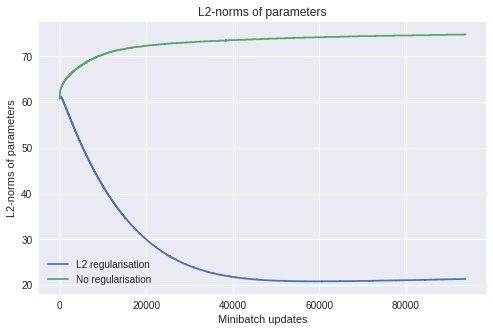

In [49]:
plt.figure(figsize=(8,5))
plt.plot(range(len(norms1)), norms1, label = u'L2 regularisation')
plt.plot(range(len(norms2)), norms2, label = u'No regularisation')
plt.title("L2-norms of parameters")
plt.xlabel('Minibatch updates')
plt.ylabel('L2-norms of parameters')
plt.legend()
plt.show()

Text(0.5,1,'Training error per epoch')

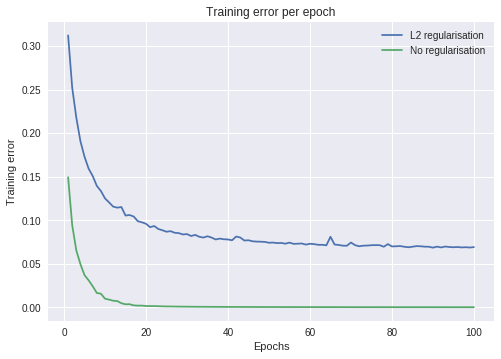

In [50]:
plt.figure()
plt.plot(np.linspace(1,epochs,epochs), lossv1, label = u'L2 regularisation')
plt.plot(np.linspace(1,epochs,epochs), lossv2, label = u'No regularisation')
plt.xlabel('Epochs')
plt.ylabel('Training error')
plt.legend(loc='upper right')
plt.title('Training error per epoch')